In [1]:
import cv2

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [2]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
image_gen = ImageDataGenerator(#rotation_range=30, # rotate the image 30 degrees
                               #width_shift_range=0.1, # Shift the pic width by a max of 10%
                               #height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               #shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               #zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               #fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [4]:
#image_gen.flow_from_directory('positions/train')
image_gen.flow_from_directory('actions/train')

Found 795 images belonging to 4 classes.


In [5]:
image_gen.flow_from_directory('actions/test')

Found 200 images belonging to 4 classes.


### Resizing Images

Let's have Keras resize all the images to 150 pixels by 150 pixels once they've been manipulated.

In [6]:
# width,height,channels
image_shape = (150,150,3)

# Creating the Model

In [7]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [8]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, not binary!
model.add(Dense(4))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', #not binary for the poses
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

### Training the Model

In [10]:
batch_size = 16

train_image_gen = image_gen.flow_from_directory('actions/train',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical') #catagoricalnfor the poses

Found 795 images belonging to 4 classes.


In [6]:
#print(next(train_image_gen))
#train_image_gen.shape

In [11]:
test_image_gen = image_gen.flow_from_directory('actions/test',
                                               target_size=image_shape[:2],
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 200 images belonging to 4 classes.


In [12]:
train_image_gen.class_indices

{'fall': 0, 'sit': 1, 'stand': 2, 'walk': 3}

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
results = model.fit_generator(train_image_gen,epochs=10,
                              steps_per_epoch=150,
                              validation_data=test_image_gen,
                             validation_steps=12)

Epoch 1/10
150/150 [==============================] - 167s 1s/step - loss: 1.0078 - acc: 0.5752 - val_loss: 0.6405 - val_acc: 0.7300
Epoch 2/10
150/150 [==============================] - 149s 996ms/step - loss: 0.5150 - acc: 0.8087 - val_loss: 0.5850 - val_acc: 0.8250
Epoch 3/10
150/150 [==============================] - 144s 960ms/step - loss: 0.2897 - acc: 0.8942 - val_loss: 0.4110 - val_acc: 0.8750
Epoch 4/10
150/150 [==============================] - 135s 902ms/step - loss: 0.1714 - acc: 0.9394 - val_loss: 0.5297 - val_acc: 0.8650
Epoch 5/10
150/150 [==============================] - 172s 1s/step - loss: 0.1232 - acc: 0.9594 - val_loss: 0.7046 - val_acc: 0.8750
Epoch 6/10
150/150 [==============================] - 145s 968ms/step - loss: 0.1065 - acc: 0.9661 - val_loss: 0.6324 - val_acc: 0.8850
Epoch 7/10
150/150 [==============================] - 109s 727ms/step - loss: 0.0679 - acc: 0.9779 - val_loss: 0.7049 - val_acc: 0.8650
Epoch 8/10
150/150 [==============================] - 

In [15]:
model.save('model1.h5')

# Evaluating the Model

In [16]:
results.history['acc']

[0.5748427674205548,
 0.8088050317714299,
 0.8943396228664326,
 0.9392033544226512,
 0.9597484277729218,
 0.9660377359740139,
 0.9777777777777777,
 0.9773584905660377,
 0.9815513628083955,
 0.9832285115303984]

In [17]:
import matplotlib.pyplot as plt

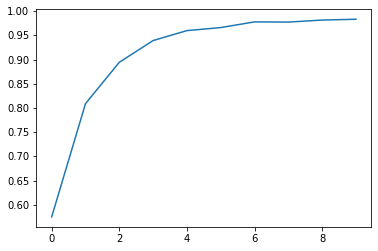

In [18]:
plt.plot(results.history['acc'])

In [4]:
from keras.models import load_model

In [5]:
new_model = load_model('model1.h5')

# Predicting on new images

In [21]:
train_image_gen.class_indices

{'fall': 0, 'sit': 1, 'stand': 2, 'walk': 3}

In [19]:
v = cv2.imread('POSE3.jpg')
v.shape

(802, 350, 3)

In [6]:
import numpy as np
from keras.preprocessing import image

pose_file = 'testing/walk5.jpg'

pose = image.load_img(pose_file, target_size=(150, 150))

pose = image.img_to_array(pose)

pose = np.expand_dims(pose, axis=0) #so the network can think its a batch of one image
pose = pose/255

In [7]:
prediction_prob = new_model.predict(pose)
new_model.predict_classes(pose) 
                               

array([3])

In [34]:
# Output prediction
print(prediction_prob) #how sure is it that the image belongs to the array it chose 

[[1.7743273e-06 3.3431544e-07 1.8688984e-07 3.5053063e-02]]


In [8]:
import numpy as np
from keras.preprocessing import image
#function to classify a pose
def predictPose(imageName):
    #resize the image since the model is trained with 150 by 150 images
    pose = image.load_img(imageName, target_size=(150,150))
    pose = image.img_to_array(pose)
    pose = np.expand_dims(pose, axis=0)
    pose = pose/255
    
    #actual classification
    prediction_prob = new_model.predict(pose)
    #returns which pose
    poseNumber = new_model.predict_classes(pose)
    #print(prediction_prob)
    return poseNumber[0]+1
    
    

In [9]:
import time
import numpy as np
from PIL import Image
import os
import sys

In [10]:
def getAllImages(rootdir):
    """Gets all of the images in a folder and runs them through OpenPose.
    You just need to run this function with the folder of pose images"""
    path, dirs, files = next(os.walk(rootdir))
    file_count = len(files) - 1
    poseList = []
    action = 0
    actionList = []
    i = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            # print os.path.join(subdir, file)
            filepath = subdir + os.sep + file

            if filepath.endswith(".jpg"):
                i += 1
                #printProgressBar(i + 1, file_count, prefix='Progress:', suffix='Complete', length=50)
                print("processing image "+ str(filepath))
                action = predictPose(filepath)
                print(action)
                actionList.append(action)
    return actionList
                

In [52]:
t = time.time()
print("Time at start: " + str((time.time() - t)))
result = getAllImages('testing/walk')
print("Time taken: " + str((time.time() - t)))

Time at start: 5.888938903808594e-05
processing image testing/walk/63.jpg
4
processing image testing/walk/77.jpg
1
processing image testing/walk/62.jpg
4
processing image testing/walk/74.jpg
4
processing image testing/walk/60.jpg
4
processing image testing/walk/49.jpg
4
processing image testing/walk/61.jpg
4
processing image testing/walk/75.jpg
4
processing image testing/walk/59.jpg
4
processing image testing/walk/71.jpg
3
processing image testing/walk/65.jpg
4
processing image testing/walk/64.jpg
4
processing image testing/walk/70.jpg
4
processing image testing/walk/58.jpg
4
processing image testing/walk/8.jpg
1
processing image testing/walk/66.jpg
4
processing image testing/walk/72.jpg
4
processing image testing/walk/73.jpg
1
processing image testing/walk/67.jpg
4
processing image testing/walk/9.jpg
3
processing image testing/walk/14.jpg
4
processing image testing/walk/28.jpg
3
processing image testing/walk/29.jpg
4
processing image testing/walk/15.jpg
1
processing image testing/walk

In [53]:

fall = 0
walk = 0
stand = 0
sit = 0
size = len(result)
for i in result:
    if i == 1:
        fall += 1
    elif i == 2:
        sit += 1
    elif i == 3:
        stand += 1
    elif i == 4:
        walk += 1
    else:
        print("error")
        
print('fall:', fall, (fall/size)*100)
print('sit:', sit, (sit/size)*100)
print('stand:', stand, (stand/size)*100)
print('walk:', walk, (walk/size)*100)

fall: 11 14.102564102564102
sit: 2 2.564102564102564
stand: 9 11.538461538461538
walk: 56 71.7948717948718


In [26]:
#sample run
print(predictPose('POSE22.jpg'))

2


In [41]:
import os.path
def detectAllPlayers():
    path = 'players/player'
    detected_poses = []
    player = 0
    pose = 0
    #to check if the player exists
    playerExists = os.path.isfile(path+str(player)+'.jpg') 

    while playerExists:
        pose = predictPose(path+str(player)+'.jpg')
        detected_poses.append(pose)
        player +=1
        playerExists = os.path.isfile(path+str(player)+'.jpg')   

    return detected_poses

In [42]:

for player in range(len(detectAllPlayers())):
    print("Player", player, "is displaying pose", detected_poses[player])

Player 0 is displaying pose 2
Player 1 is displaying pose 6
Player 2 is displaying pose 2


In [47]:
#game play
def simonSays(correctPose):
    playerPoses = detectAllPlayers()
    for player in range(len(playerPoses)):
        if playerPoses[player] == correctPose:
            print("Player", player, "congrats! You've done the pose correctly")
        else:
            print("Player", player, "uh-oh! You've done the pose incorrectly")
    


In [48]:
simonSays(2)

Player 0 congrats! You've done the pose correctly
Player 1 uh-oh! You've done the pose incorrectly
Player 2 congrats! You've done the pose correctly
